### Install necessary packages

In [ ]:
pip install -r ./requirements/cn_author_collab_net_requirements.txt

### Import section

In [106]:
import networkx as nx
from networkx.algorithms import community # ~louvain
import os
#import community as community_louvain
import community.community_louvain as community_louvain

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import colorcet as cc
from matplotlib.colors import ListedColormap
from lib.crisp_partition import leiden as leiden_seed # Here, I am using a self-modified version of the leiden algorithm that allows for a random seed to be set


import cdlib as cd
from cdlib import algorithms
from cdlib import evaluation

import re
# Fonts for plots
#mpl.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_columns', None)

# Path to data retrieval and storage
path = os.path.abspath('')

Import cleaned authors

In [51]:
authors = pd.read_csv(path + "/cn_authors_clean.csv")
len(authors) #32479

32479

In [52]:
authors.head()

,item_id,author_seq_nr,given_name,family_name,corresponding,aff_seq_nr,organization,wos_suborganization,vendor_org_id,family_name_lower_wo_space,given_name_lower_wo_space,name,suborga_modified,country,city,pubyear
0,WOS:000075569500101,1,JL,Krichmar,True,NaN,NaN,NaN,NaN,krichmar,jl,krichmar_jeffreyl,"{""Dept Cognit Sci""}",USA,Fairfax,1998
1,WOS:000075569500101,2,GA,Ascoli,False,NaN,NaN,NaN,NaN,ascoli,ga,ascoli_giorgioa,"{""Krasnow Inst Adv Study""}",USA,Fairfax,1998
2,WOS:000075569500101,3,JL,Olds,False,NaN,NaN,NaN,NaN,olds,jl,olds_jamesleland,"{""Schar Sch Publ Policy""}",USA,Fairfax,1998
3,WOS:000075569500101,4,L,Hunter,False,NaN,NaN,NaN,NaN,hunter,l,hunter_l,NaN,USA,Fairfax,1998
4,WOS:000086279300008,1,J,Bickle,True,NaN,NaN,NaN,NaN,bickle,j,bickle_j,NaN,USA,Greenville,2000


In [53]:
res = authors[authors['pubyear'] == 1994]
res

,item_id,author_seq_nr,given_name,family_name,corresponding,aff_seq_nr,organization,wos_suborganization,vendor_org_id,family_name_lower_wo_space,given_name_lower_wo_space,name,suborga_modified,country,city,pubyear
5757,WOS:A1994PP00800001,1,T,JOBE,True,NaN,NaN,NaN,NaN,jobe,t,jobe_t,NaN,NaN,NaN,1994
5758,WOS:A1994PP00800001,2,R,VIMAL,False,NaN,NaN,NaN,NaN,vimal,r,vimal_r,NaN,NaN,NaN,1994
5759,WOS:A1994PP00800001,3,A,KOVILPARAMBIL,False,NaN,NaN,NaN,NaN,kovilparambil,a,kovilparambil_a,NaN,NaN,NaN,1994
5760,WOS:A1994PP00800001,4,J,PORT,False,NaN,NaN,NaN,NaN,port,j,port_j,NaN,NaN,NaN,1994
5761,WOS:A1994PP00800001,5,M,GAVIRIA,False,NaN,NaN,NaN,NaN,gaviria,m,gaviria_m,NaN,NaN,NaN,1994
27408,WOS:A1994PQ38200012,1,JD,CRAWFORD,True,NaN,NaN,NaN,NaN,crawford,jd,crawford_jd,NaN,NaN,NaN,1994


### Accumulated Authorships by Year and Country

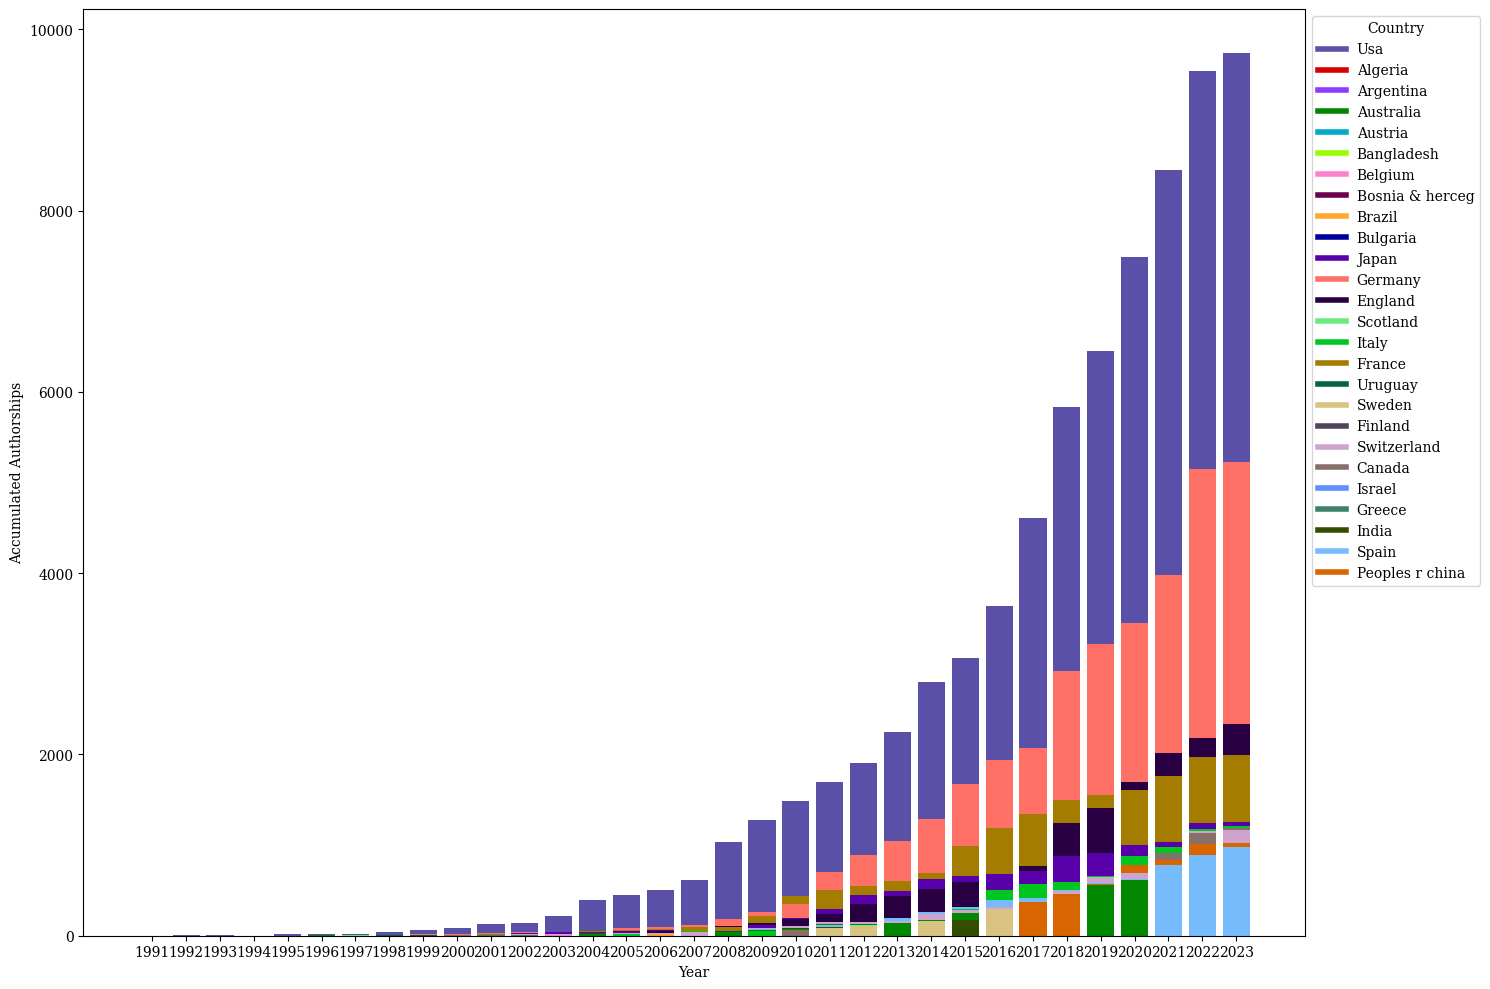

In [54]:
# copy original DF
aut = authors.copy()

# Spellcheck
aut['country'] = aut['country'].str.capitalize()

# Group by year and country
grouped = aut.groupby(['pubyear', 'country']).size().unstack(fill_value=0)
publications_cumulative = grouped.cumsum()

# list of unique years + country names
unique_years = publications_cumulative.index
country_names = publications_cumulative.columns
dict_country_color = {c:i for i,c in enumerate(country_names)}

# Create a colormap for countries
#cmap = plt.cm.get_cmap('tab20',len(country_names))
cmap = cc.glasbey_bw

# Fix problem with legend
legend_dict = {}

# Plot the data
plt.figure(figsize=(15,10))

# Create Bars for top Countries of each year
top_countries = []
for year in unique_years:
    top = publications_cumulative.loc[year].nlargest(10)
    top_countries = top.index

    bottom = np.zeros(len(top_countries))
    
    for idx, country in enumerate(top_countries):
        plt.bar(
            year,
            publications_cumulative[country][year],
            label=country,
            color=cmap[dict_country_color.get(country)],
            bottom=bottom[idx],
        )
        bottom[idx] += publications_cumulative[country][year]

         # Add new countries to the legend dictionary
        if country not in legend_dict:
            legend_dict[country] = plt.Line2D([0], [0], color=cmap[dict_country_color.get(country)], lw=4, label=country)


# Create a list of all years
all_years = list(range(min(unique_years), max(unique_years) + 1))  

# Create legend only with  entries
legend_handles = [legend_dict[country] for country in legend_dict]

#plt.title('Accumulated Authorships by Year and Country')
plt.xlabel('Year')
plt.ylabel('Accumulated Authorships')
plt.xticks(all_years)
plt.legend(handles=legend_handles,title='Country', loc='upper left', bbox_to_anchor=(1, 1))#,ncol=2)
plt.tight_layout()

plt.show()


### Top Contribution of Top Countries by Year

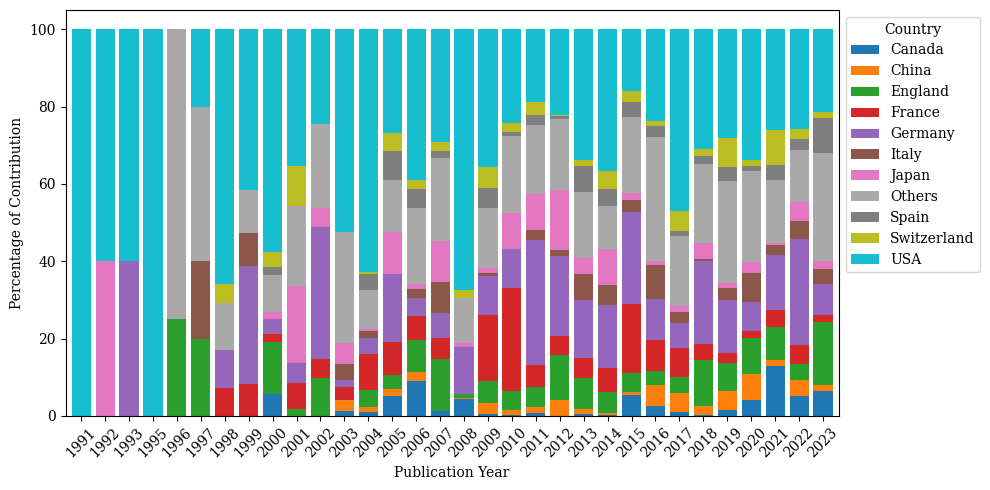

In [55]:
# copy original DF
pub = authors.copy()

# Spellcheck
pub['country'] = pub['country'].str.capitalize()
pub.loc[pub['country'].isin(['Peoples r china']) ,'country'] = 'China'
pub.loc[pub['country'].isin(['Usa']) ,'country'] = 'USA'
# Filter NaN
pub = pub.dropna(subset=['country'])

# Get the top 10 countries with the most contributions for each year
country_contributions = pub['country'].value_counts().nlargest(10)
top_countries = pub.groupby(['pubyear', 'country']).size().unstack(fill_value=0).sum().nlargest(10).index

#top_countries = [s.capitalize() for s in top_countries]


# Overwrite Non-Top Countries
pub.loc[~pub['country'].isin(top_countries), 'country'] = 'Others'


# Group filtered DataFrame by year
yearly_total = pub.groupby('pubyear').size()

# store Percentage
percentage_df = pd.DataFrame(index=yearly_total.index)

# Calculate contribution of each country for each year
for country in top_countries.union(['Others']):
    contribution_percentage = (pub[pub['country'] == country].groupby('pubyear')
                               .size().div(yearly_total, level='pubyear').mul(100).fillna(0))
    percentage_df[country] = contribution_percentage



# Plot
# plt.rcParams['font.family'] = 'serif'
# plt.rc ('xtick', labelsize = 10)
# cmap = plt.cm.get_cmap('tab20b',len(top_countries))
# Create a custom colormap with the color of the specific country changed
# cmap = plt.colormaps['viridis']
# cmap = cc.cm.glasbey_bw
# custom_cmap = cmap(np.linspace(0, 1, len(top_countries) + 1))
# custom_cmap = [0.5, 0.5, 0.5, 1.0] 

# Create cumstom Colormap
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap.insert(7,'#A9A9A9')
custom_cmap = ListedColormap(cmap)


ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 5), width=0.8,cmap=custom_cmap)

#plt.title('Percentage Contribution of Top Countries by Year')
plt.xlabel('Publication Year')
plt.ylabel('Percentage of Contribution')
plt.xticks(rotation=45)
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('contributions.pdf')
plt.show()

Extract Basic information about the 'authors' dataset

In [56]:
total_entries = len(authors)

# Get unique years and unique publications
unique_authors = authors['name'].nunique(dropna=True)  # dropna=True to exclude NaN values
unique_publications = authors['item_id'].nunique(dropna=True)

# Get start and end year
earliest_year = authors['pubyear'].min()
latest_year = authors['pubyear'].max()
unique_departments = authors['suborga_modified'].nunique(dropna=True)  # dropna=True to exclude NaN values

# Add this to the summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total Entries', 'Unique Authors', 'Unique Publications', 'Unique Departments', 'Earliest Pub. Year', 'Latest Pub. Year'],
    'Value': [total_entries, unique_authors, unique_publications, unique_departments, earliest_year, latest_year]
})


summary_df

,Metric,Value
0,Total Entries,32479
1,Unique Authors,4161
2,Unique Publications,1553
3,Unique Departments,1935
4,Earliest Pub. Year,1991
5,Latest Pub. Year,2023


Show Top 10 Departments

In [57]:
top_10_departments = authors['suborga_modified'].value_counts().head(10)

# Convert to DataFrame for better visualization
top_10_departments_df = pd.DataFrame({
    'Department': top_10_departments.index,
    'Frequency': top_10_departments.values
})

top_10_departments_df

,Department,Frequency
0,"{""Dept Neurol""}",855
1,"{""Inst Neurosci & Med INM 6""}",514
2,"{""Dept Comp Sci""}",513
3,"{""Dept Psychol""}",471
4,"{""Translat Neuromodeling Unit TNU"",""Inst Biome...",420
5,"{""Inst Adv Simulat IAS 6""}",404
6,"{""Dept Psychiat""}",354
7,"{""Dept Neurosci""}",353
8,"{""Dept Biomed Engn""}",285
9,"{""Dept Neurosci Physiol & Pharmacol""}",268


### Create Collabnet

In [59]:
G_Collabnet = nx.Graph() # Create empty graph
# Add edges to graph
for item in authors['item_id'].unique():
    # Get all authors of publication, exclude NaNs
    authors_list = authors[authors['item_id'] == item]['name'].dropna().tolist()

    # Explicitly add nodes while excluding NaNs (This step is optional? Nodes as item_id_clear should be added automatically)
    for author in authors_list:
        G_Collabnet.add_node(author)
        
    # Create an edge for every pair of authors
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            # If the edge already exists, increment its weight by 1
            if G_Collabnet.has_edge(authors_list[i], authors_list[j]):
                G_Collabnet[authors_list[i]][authors_list[j]]['weight'] += 1
            # Else, create a new edge with weight 1
            else:
                G_Collabnet.add_edge(authors_list[i], authors_list[j], weight=1)

In [60]:
# Save Network to GEXF file
nx.write_gexf(G_Collabnet, "G_Collabnet.gexf")

### Analysis of the author collaboration network

>Network metrics and comparison of the whole authors data and the data from 2005 onwards

In [61]:
# Subset of authors dataframe
authors_young = authors[authors['pubyear'] >= 2010]

Create graph for younger collaboration network

In [62]:

G_Collabnet_young = nx.Graph()

# Add edges to graph (Same code as before but for the filtered dataframe)
for item in authors_young['item_id'].unique():
    authors_list = authors_young[authors_young['item_id'] == item]['name'].dropna().tolist()
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            if G_Collabnet_young.has_edge(authors_list[i], authors_list[j]):
                G_Collabnet_young[authors_list[i]][authors_list[j]]['weight'] += 1
            else:
                G_Collabnet_young.add_edge(authors_list[i], authors_list[j], weight=1)

Function to calculate networks metrics

In [63]:

def calculate_metrics(G):
    metrics = {}
    # Basic metrics
    metrics['# Nodes'] = G.number_of_nodes()
    metrics['# Edges'] = G.number_of_edges()
    metrics['# Isolated nodes'] = len(list(nx.isolates(G))) # Isolated nodes have no edges, so an author who has not collaborated with anyone else!
    metrics['% Isolated nodes'] = (metrics['# Isolated nodes'] / metrics['# Nodes']) * 100 if metrics['# Nodes'] != 0 else 0 # added if statement to avoid division by zero
    
    #Advanced metrics
    metrics['# Connected components'] = nx.number_connected_components(G)
    metrics['Size of largest components'] = len(max(nx.connected_components(G), key=len))
    metrics['Av. degree'] = sum(dict(G.degree()).values()) / metrics['# Nodes']
    metrics['# Communities'] = len(community.greedy_modularity_communities(G))

    partition = community_louvain.best_partition(G)     # Compute best partition of graph nodes for modularity
    metrics['Modularity'] = community_louvain.modularity(partition, G)
    
    metrics['Clustering Coefficient'] = nx.average_clustering(G)


    return metrics


Compare created Graphs

In [64]:

# Metrics for both graphs
metrics_original = calculate_metrics(G_Collabnet)
metrics_young = calculate_metrics(G_Collabnet_young)

#Df with metrics side-by-side
df_metrics = pd.DataFrame({'Metric': list(metrics_original.keys()),
                           'G': list(metrics_original.values()),
                           'G after 2010': list(metrics_young.values())})


In [65]:
df_metrics

,Metric,G,G after 2010
0,# Nodes,4161.000000,3466.000000
1,# Edges,15703.000000,14031.000000
2,# Isolated nodes,105.000000,0.000000
3,% Isolated nodes,2.523432,0.000000
4,# Connected components,759.000000,564.000000
5,Size of largest components,1015.000000,815.000000
6,Av. degree,7.547705,8.096365
7,# Communities,784.000000,581.000000
8,Modularity,0.870113,0.867237
9,Clustering Coefficient,0.806957,0.844340


Find Cluster with Leiden Algorithm

In [66]:
#from lib.crisp_partition import leiden as leiden_seed
#coms = leiden_seed(G_Collabnet, weights='weight')
#coms_young = leiden_seed(G_Collabnet_young, weights='weight')

num_seeds = 20 # results for 1000 seeds include even 10 clusters
seeds = range(num_seeds)

# list to store number of clusters for all seeds
num_communities = []
all_communities = []

for seed in seeds:
    #coms = algorithms.leiden(G_RefNet, weights='weight')
    # use modified version of the leiden module
    coms = leiden_seed(G_Collabnet, weights='weight', seed=seed)
    num_communities.append(len(coms.communities))
    all_communities.append(coms)#.communities)

Visualize

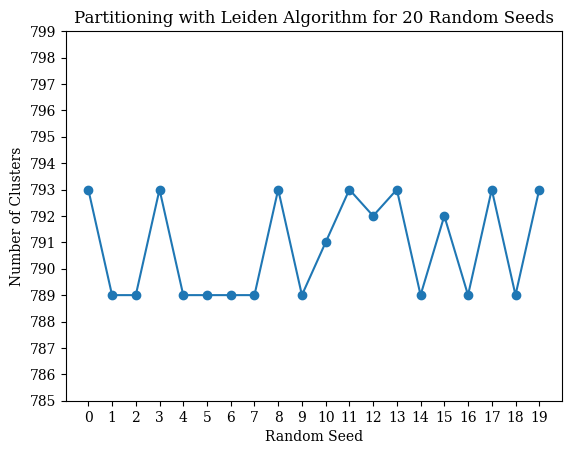

In [67]:
plt.plot(seeds, num_communities, marker='o')
plt.yticks(range(785,800))
plt.xticks(range(0,20))
plt.xlabel('Random Seed')
plt.ylabel('Number of Clusters')
plt.title('Partitioning with Leiden Algorithm for 20 Random Seeds')
plt.show()

In [ ]:
for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that will merge elements from two or more data sources into one
    print("Seed:", seed)
    for idx, community in enumerate(communities.communities):
        print("Community", idx+1, "Size:", len(community))

Create a metric to decide on a seed

In [68]:
embeddedness_values = []
hub_values = []
zmod_values = []

# Get embeddedness
for c in all_communities: # all_communities contains the clusterings for all seeds
    embeddedness_value = evaluation.avg_embeddedness(G_Collabnet, c)
    embeddedness_values.append(embeddedness_value)

# Get dominance
for c in all_communities:
    hub_value = evaluation.hub_dominance(G_Collabnet, c)
    hub_values.append(hub_value)

# Get Z-score
for c in all_communities:
    zmod_value = evaluation.z_modularity(G_Collabnet, c)
    zmod_values.append(zmod_value)


df_embseeds = pd.DataFrame({"Embeddedness": embeddedness_values})
df_hub = pd.DataFrame({"Hub Dominance": hub_values})
df_zmod = pd.DataFrame({"Modularity (Z-score-based)": zmod_values})


Visualize the different scores

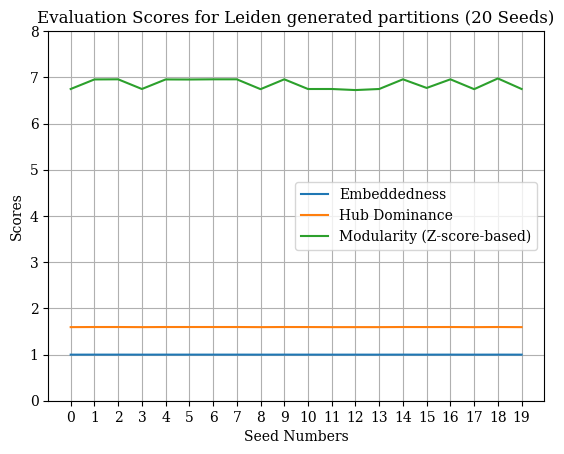

In [69]:
seeds = list(range(num_seeds))

embeddedness_scores = [c[2] for c in embeddedness_values] # taking the third value of the results (tuple)
hub_scores = [c[2] for c in hub_values]
modularity_scores = [c[2] for c in zmod_values]

plt.plot(seeds, embeddedness_scores, label='Embeddedness')
plt.plot(seeds, hub_scores, label='Hub Dominance')
plt.plot(seeds, modularity_scores, label='Modularity (Z-score-based)')

plt.xlabel('Seed Numbers')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Leiden generated partitions (20 Seeds)')
plt.xticks(range(0,20))
plt.ylim(0, 8)
plt.grid(True)
plt.legend()

plt.show()

Select seed

In [70]:
coms = leiden_seed(G_Collabnet, weights='weight', seed =5)

### Assess central authors by centrality measures

>Note: For the centrality measures to work, the graph must be connected, which means there must be a series of edges that connets every node to any other node. In this case, the full graph is not connected. But NetworkX should handle isolated nodes appropriately and assign them a centrality of zero. 

Function to calculate the top 10 authors by centrality

In [71]:
# Get sorted list of tuples with top 10 authors and their centrality score
def top_10_central(G, centrality_type):
    if centrality_type == 'betweenness': # Check type of centrality metric to calculate
        centrality_dict = nx.betweenness_centrality(G)
    elif centrality_type == 'closeness':
        centrality_dict = nx.closeness_centrality(G)
    else:
        return "Invalid centrality type" # added this to avoid errors
        
    sorted_centrality = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    return sorted_centrality



# Calculate top 10 central nodes based on betweenness centrality for both graphs
top_10_betweenness_original = top_10_central(G_Collabnet, 'betweenness')
top_10_betweenness_young = top_10_central(G_Collabnet_young, 'betweenness')

# Calculate top 10 central nodes based on closeness centrality for both graphs
top_10_closeness_original = top_10_central(G_Collabnet, 'closeness')
top_10_closeness_young = top_10_central(G_Collabnet_young, 'closeness')

# Combine them into a DataFrame for easier comparison
df_top_10_centralities = pd.DataFrame({
    'Top 10 Betweenness - Original': [f"{x[0]} ({x[1]:.3f})" for x in top_10_betweenness_original],
    'Top 10 Betweenness - Young': [f"{x[0]} ({x[1]:.3f})" for x in top_10_betweenness_young],
    'Top 10 Closeness - Original': [f"{x[0]} ({x[1]:.3f})" for x in top_10_closeness_original],
    'Top 10 Closeness - Young': [f"{x[0]} ({x[1]:.3f})" for x in top_10_closeness_young]
})



In [72]:
df_top_10_centralities

,Top 10 Betweenness - Original,Top 10 Betweenness - Young,Top 10 Closeness - Original,Top 10 Closeness - Young
0,maass_wolfgang (0.020),maass_wolfgang (0.018),morrison_abigail (0.061),morrison_abigail (0.061)
1,logothetis_nikosk (0.020),logothetis_nikosk (0.018),davison_andrewp (0.059),davison_andrewp (0.060)
2,deco_gustavo (0.019),deco_gustavo (0.017),diesmann_markus (0.059),diesmann_markus (0.059)
3,jirsa_viktork (0.016),jirsa_viktork (0.015),mueller_eric (0.058),mueller_eric (0.058)
4,diesmann_markus (0.014),diesmann_markus (0.013),eppler_jochenmartin (0.058),eppler_jochenmartin (0.058)
5,subramoney_anand (0.014),subramoney_anand (0.013),muller_eilif (0.057),schemmel_johannes (0.058)
6,breakspear_michael (0.012),morrison_abigail (0.010),schemmel_johannes (0.057),petrovici_mihaia (0.057)
7,friston_karlj (0.011),breakspear_michael (0.010),petrovici_mihaia (0.057),meier_karlheinz (0.057)
8,morrison_abigail (0.011),friston_karlj (0.010),meier_karlheinz (0.057),diazpier_sandra (0.057)
9,hines_michaell (0.009),hines_michaell (0.009),diazpier_sandra (0.057),hopkins_michaelw (0.057)


Find Nodes of different clusters in both networks

In [73]:
# Function to extract communities
def extract_communities(partition):
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    return communities

# communities to dataframe
def communities_to_df(communities):
    data = []
    for community_id, nodes in communities.items():
        for node in nodes:
            data.append({'Community_ID': community_id, 'Node': node})
    return pd.DataFrame(data)

# Get the partitions
partition_original = community_louvain.best_partition(G_Collabnet)
partition_young = community_louvain.best_partition(G_Collabnet_young)

# Extract communities for both graphs
communities_original = extract_communities(partition_original)
communities_young = extract_communities(partition_young)

# Alter them to Dataframes
df_communities_original = communities_to_df(communities_original)
df_communities_young = communities_to_df(communities_young)

# Save to CSV
df_communities_original.to_csv('communities_original.csv', index=False)
df_communities_young.to_csv('communities_young.csv', index=False)

df_communities_original

,Community_ID,Node
0,0,krichmar_jeffreyl
1,0,olds_jamesleland
2,0,zaldivar_andrew
3,0,asher_derrike
4,0,avery_michaelc
...,...,...
4156,50,bankes_sc
4157,50,margoliash_d
4158,133,somers_dc
4159,133,nelson_sb


In [74]:
df_communities_young

,Community_ID,Node
0,0,bland_amyr
1,0,schaefer_alexandre
2,1,thornton_john
3,1,srbic_andrew
4,1,main_linda
...,...,...
3461,330,gao_chenghua
3462,409,psarellis_yorgosmm
3463,409,kavousanakis_michail
3464,409,henson_michaelaa


In [75]:
# Number of communities in the original network
num_communities_original = len(set(partition_original.values()))

# Number of communities in the young network
num_communities_young = len(set(partition_young.values()))

print(f"Number of communities in the original network: {num_communities_original}")
print(f"Number of communities in the young network: {num_communities_young}")


Number of communities in the original network: 792
Number of communities in the young network: 590


### Triadic Closures due to Collaboration

In [76]:
# map author to years in which they collaborated
collaborations = {}

# map author to their collaborations in a specific year
author_to_collaborations = {}

for index, row in authors.iterrows():
    author = row['name'] 
    year = row['pubyear'] 
    item = row['item_id']
    
    if not isinstance(author, str):
        continue  # avoid errors because of NaN values
    
    # List all co-authors, exclude NaNs
    coauthors = authors[authors['item_id'] == item]['name'].dropna().tolist()
    if author in coauthors: 
        coauthors.remove(author) # remove author from co-authors list
    
    if not coauthors:  # skip if there are no co-authors
        continue
    
    if author not in author_to_collaborations: # add author if he has not yet appeared
        author_to_collaborations[author] = {}
    author_to_collaborations[author][year] = coauthors  # map author to collaboration

    for coauthor in coauthors: # Update collaborations
        pair = tuple(sorted([author, coauthor])) # sort to avoid duplicates like AB and BA
        if pair not in collaborations: # initialize new pair's
            collaborations[pair] = [] # create a new pair list
        collaborations[pair].append(year)




# Triadic closure checking
triadic_closures = [] # list to store triadic closures

for (A, B), years in collaborations.items(): # loop through all pairs of authors
    last_collab_year = max(years) # get the last collaboration year

    # check for other collaborations of B without A after last_collab_year
    for year, collabs_of_B in author_to_collaborations.get(B, {}).items():
        if year <= last_collab_year: 
            continue

        if A not in collabs_of_B: 
            for C in collabs_of_B: # check if A has collaboration with those authors in the future
                pair = tuple(sorted([A, C]))
                if pair in collaborations and any(y > year for y in collaborations[pair]): # check if A and C collaborated in years > year (which is B's collab with C)
                    triadic_closures.append((A, B, C)) # Add triadic closure to list

print(f"Triadic closures: {len(triadic_closures)}") # 1716 triadic closures

Triadic closures: 1716


### Clustering Coefficient

In [77]:
avg_clustering_coefficient = nx.average_clustering(G_Collabnet, weight='weight')
avg_clustering_coefficient


0.004425628808387083

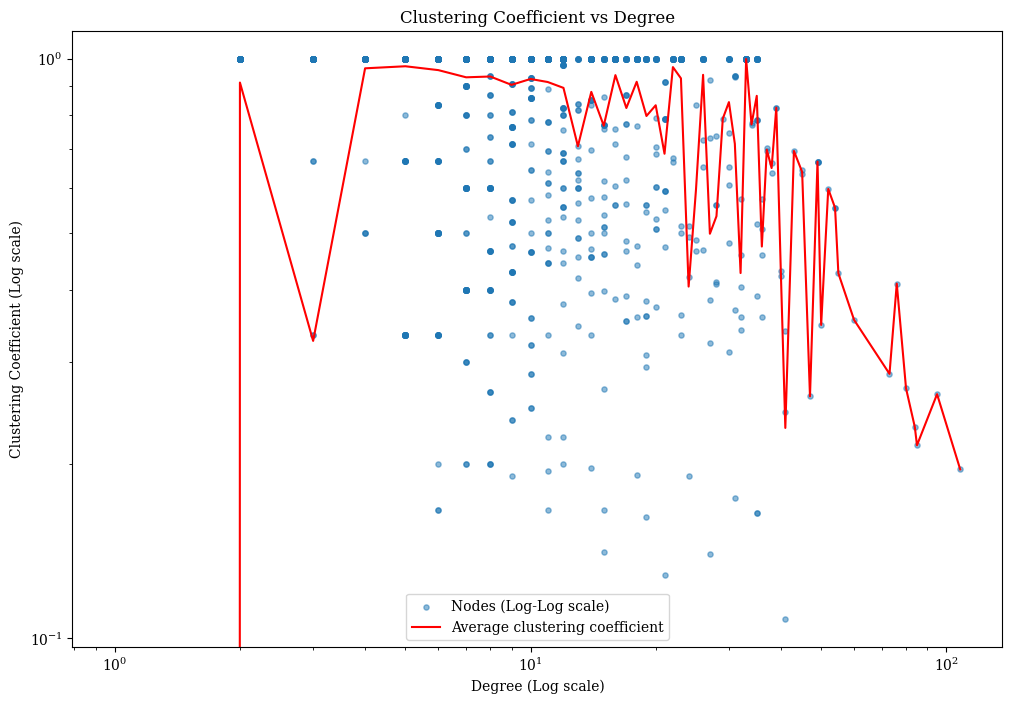

In [78]:
G = G_Collabnet  # for simplicity

# get degree and local clustering coefficient for each node
degrees = [degree for node, degree in G.degree()]
coeffs = [nx.clustering(G, node) for node in G.nodes()]

# get average local clustering coefficient for each degree
avg_coeffs = {}
for degree, coeff in zip(degrees, coeffs):
    if degree not in avg_coeffs:
        avg_coeffs[degree] = []
    avg_coeffs[degree].append(coeff)

# prepare average data for plot
avg_degree = sorted(list(avg_coeffs.keys()))
avg_coeff = [np.mean(avg_coeffs[deg]) for deg in avg_degree]

# Plot data
plt.figure(figsize=(12, 8))
plt.scatter(degrees, coeffs, alpha=0.5, s=14, label='Nodes (Log-Log scale)')
plt.plot(avg_degree, avg_coeff, 'r-', label='Average clustering coefficient')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Log scale)')
plt.ylabel('Clustering Coefficient (Log scale)')
plt.legend()
plt.title('Clustering Coefficient vs Degree')
plt.show()

### Create Profiles for most central authors

Function to recapitalize names

In [79]:
def format_name(name): # Since I have previously modified the names
    return ' '.join([word.capitalize() for word in name.split('_')[::-1]])

Function to plot number of publications per year

In [103]:
def plot_publications_per_year(name, df):
    formatted_name = format_name(name)
    df_author = df[df['name'] == name]
    yearwise_counts = df_author['pubyear'].value_counts().sort_index()
    
    plt.figure(figsize=(4, 2))
    yearwise_counts.plot(kind='bar')#, color='skyblue')
    #plt.title(f'Number of Publications per Year for {formatted_name}')
    plt.xlabel('Year', labelpad=10)
    plt.ylabel('Number of Publications', labelpad=10)
    plt.tight_layout()
    plt.savefig(f'pubs_per_year_{formatted_name}.pdf')
    plt.show()

Function to plot direct collaborators graph view

In [81]:
def plot_collaborator_subgraph(name, G):
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    
    formatted_name = format_name(name)
    neighbors = list(G.neighbors(name))
    neighbors.append(name)  # Add the main author to the list
    
    H = G.subgraph(neighbors).copy()  # Make a copy of the subgraph
    
    # Remove self-loops from the subgraph
    H.remove_edges_from(nx.selfloop_edges(H))
    
    # Format the node labels
    formatted_labels = {node: format_name(node) for node in H.nodes()}
    # apply labels to new Subgraph
    I = nx.relabel_nodes(H,formatted_labels,True)
    
    pos = nx.spring_layout(I)
    nx.draw_spring(I, node_color='lightblue', edge_color='gray', font_family='STIXGeneral')

    nx.write_gexf(I, f'{path}\gexf\{name}.gexf')
    #plt.title(f"Collaborators of {formatted_name}")
    #plt.show()

Function get most frequent collaborators (10)

In [82]:

def most_frequent_collaborators(name, df):
    formatted_name = format_name(name)
    df_collabs = df[df['item_id'].isin(df[df['name'] == name]['item_id'].tolist())]
    df_collabs = df_collabs[df_collabs['name'] != name]
    frequent_collabs = df_collabs['name'].value_counts().head(10)  # top 10 collaborators
    return frequent_collabs

wrapper function to visualize publications and collaborators for any author

In [83]:
def visualize_author(name):
    formatted_name = format_name(name)
    plot_publications_per_year(name, authors)
    
    # Plot direct collaborators subgraph
    plot_collaborator_subgraph(name, G_Collabnet)
    
    # Display most frequent collaborators
    frequent_collabs = most_frequent_collaborators(name, authors)
    print(f"\nMost Frequent Collaborators for {formatted_name}:")
    print(frequent_collabs)

In [84]:
df_top_10_centralities

,Top 10 Betweenness - Original,Top 10 Betweenness - Young,Top 10 Closeness - Original,Top 10 Closeness - Young
0,maass_wolfgang (0.020),maass_wolfgang (0.018),morrison_abigail (0.061),morrison_abigail (0.061)
1,logothetis_nikosk (0.020),logothetis_nikosk (0.018),davison_andrewp (0.059),davison_andrewp (0.060)
2,deco_gustavo (0.019),deco_gustavo (0.017),diesmann_markus (0.059),diesmann_markus (0.059)
3,jirsa_viktork (0.016),jirsa_viktork (0.015),mueller_eric (0.058),mueller_eric (0.058)
4,diesmann_markus (0.014),diesmann_markus (0.013),eppler_jochenmartin (0.058),eppler_jochenmartin (0.058)
5,subramoney_anand (0.014),subramoney_anand (0.013),muller_eilif (0.057),schemmel_johannes (0.058)
6,breakspear_michael (0.012),morrison_abigail (0.010),schemmel_johannes (0.057),petrovici_mihaia (0.057)
7,friston_karlj (0.011),breakspear_michael (0.010),petrovici_mihaia (0.057),meier_karlheinz (0.057)
8,morrison_abigail (0.011),friston_karlj (0.010),meier_karlheinz (0.057),diazpier_sandra (0.057)
9,hines_michaell (0.009),hines_michaell (0.009),diazpier_sandra (0.057),hopkins_michaelw (0.057)


Test function for 1 author

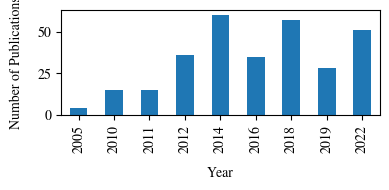


Most Frequent Collaborators for Abigail Morrison:
name
diesmann_markus        131
eppler_jochenmartin     64
igarashi_jun            57
kunkel_susanne          55
helias_moritz           54
weidel_philipp          49
plotnikov_dimitri       38
marin_boris             38
plesser_hanse           36
potjans_wiebke          30
Name: count, dtype: int64


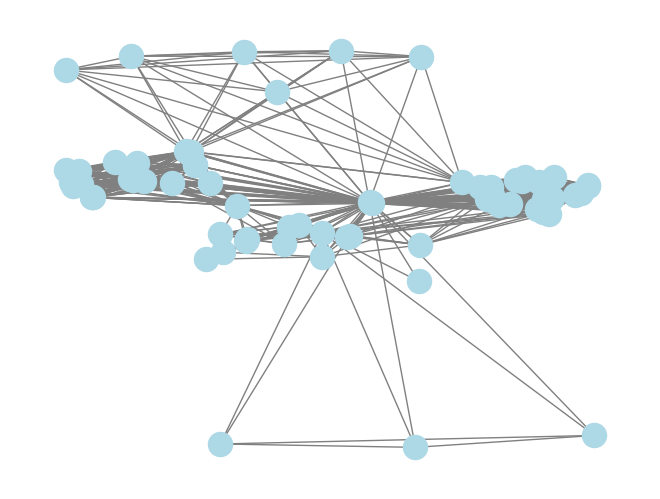

In [104]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
visualize_author('morrison_abigail')

Run function for all top 10 authors

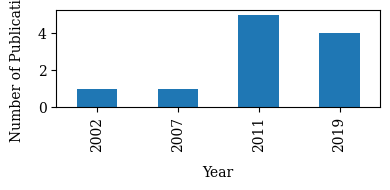


Most Frequent Collaborators for Wolfgang Maass:
name
kappel_david         12
rasch_maltej         12
hoff_michael          8
logothetis_nikosk     8
kaiser_jacques        4
schuch_klaus          4
dillmann_ruediger     4
roennau_arne          4
legenstein_robert     4
subramoney_anand      4
Name: count, dtype: int64


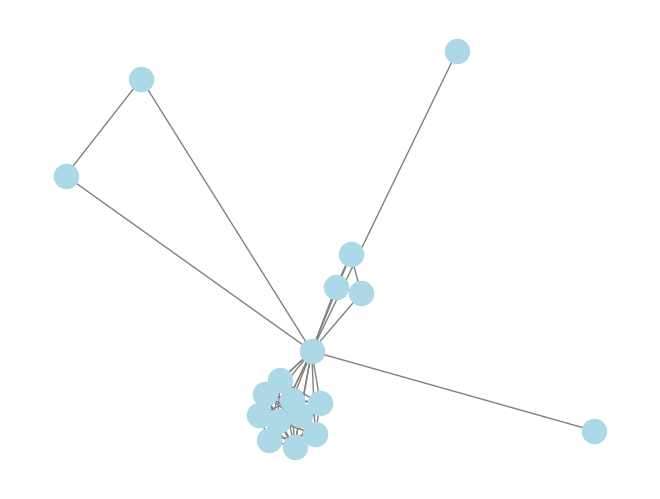

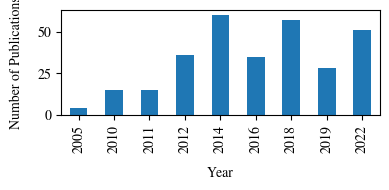


Most Frequent Collaborators for Abigail Morrison:
name
diesmann_markus        131
eppler_jochenmartin     64
igarashi_jun            57
kunkel_susanne          55
helias_moritz           54
weidel_philipp          49
plotnikov_dimitri       38
marin_boris             38
plesser_hanse           36
potjans_wiebke          30
Name: count, dtype: int64


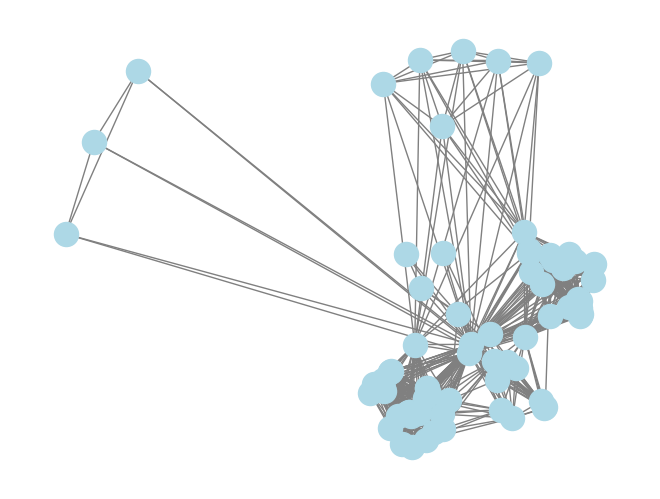

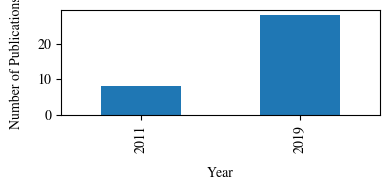


Most Frequent Collaborators for Nikosk Logothetis:
name
deco_gustavo            70
cabral_joana            42
tagliazucchi_enzo       42
laufs_helmut            42
kringelbach_mortenll    42
cruzat_josephine        28
rasch_maltej            12
schuch_klaus             4
maass_wolfgang           4
Name: count, dtype: int64


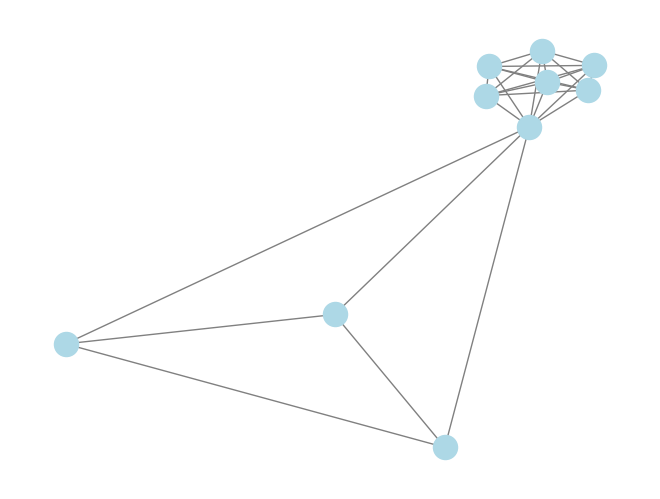

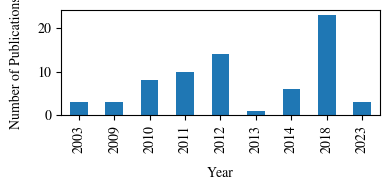


Most Frequent Collaborators for Andrewp Davison:
name
morrison_abigail       57
marin_boris            38
plotnikov_dimitri      38
gleeson_padraig        33
hines_michaell         33
eppler_jochenmartin    32
diesmann_markus        30
mueller_eric           29
crook_sharonm.         28
crook_sharonm          26
Name: count, dtype: int64


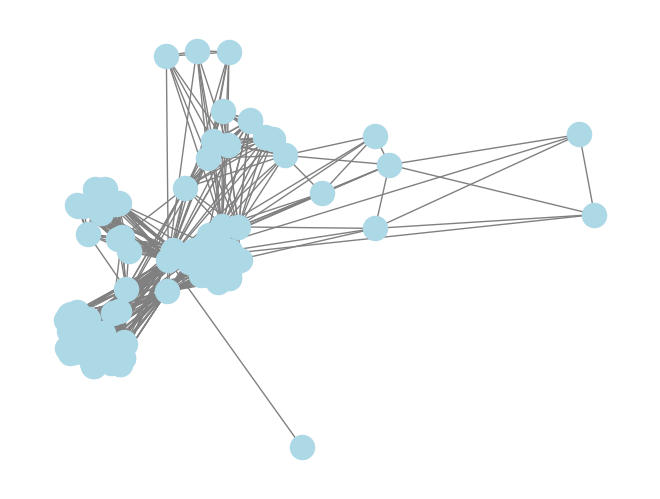

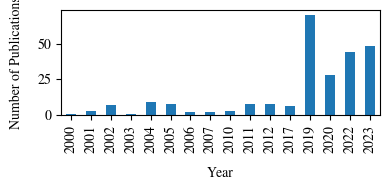


Most Frequent Collaborators for Gustavo Deco:
name
kringelbach_mortenll    111
rosas_fernandoee         64
cabral_joana             53
ruffini_giulio           48
tagliazucchi_enzo        42
laufs_helmut             42
sorianomas_carles        33
moreira_pedro            33
morgado_pedro            33
carhartharris_robin      32
Name: count, dtype: int64


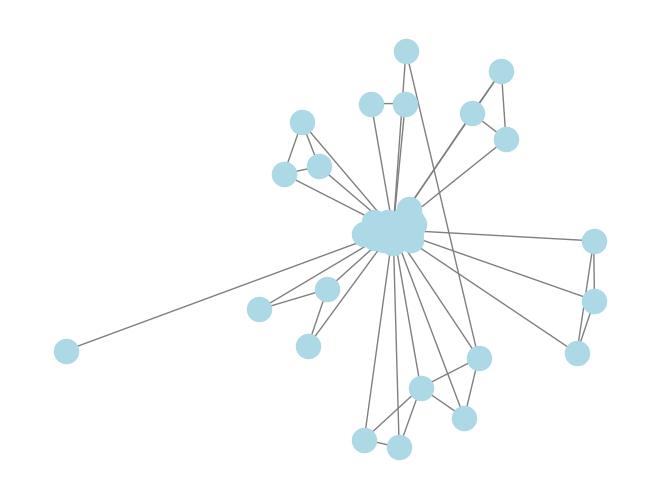

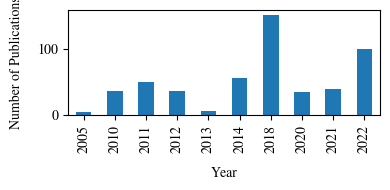


Most Frequent Collaborators for Markus Diesmann:
name
helias_moritz          195
morrison_abigail       130
kunkel_susanne         101
jordan_jakob            97
senk_johanna            89
ippen_tammo             80
plesser_hanse           80
vanalbada_sachaj        59
eppler_jochenmartin     53
igarashi_jun            53
Name: count, dtype: int64


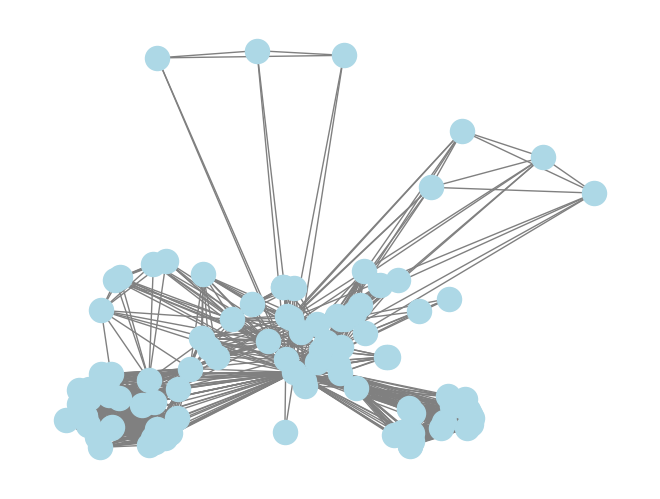

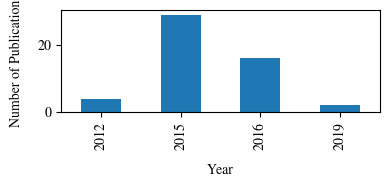


Most Frequent Collaborators for Viktork Jirsa:
name
ritter_petra              162
rothmeier_simon            64
matzke_henrik              52
llarena_adalberto          52
schirner_michael           51
vollbrecht_daniel          39
solodkin_ana               34
mcintosh_anthonyrandal     29
breakspear_michael         20
rojas_raul                 13
Name: count, dtype: int64


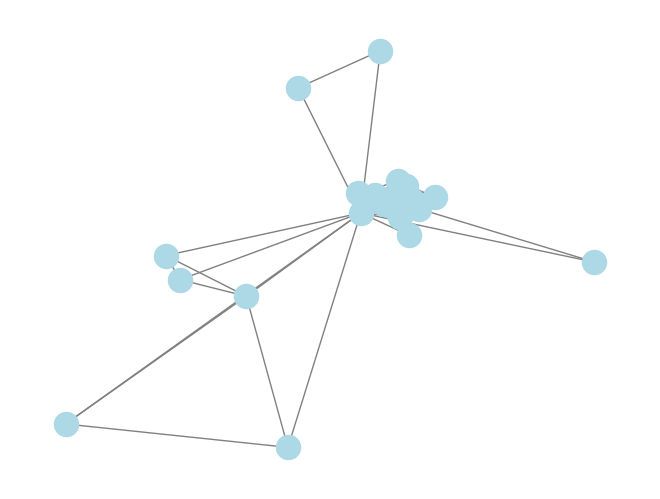

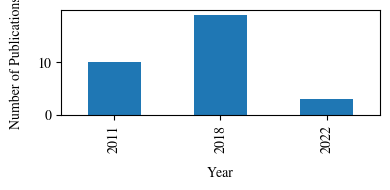


Most Frequent Collaborators for Eric Mueller:
name
morrison_abigail           57
plotnikov_dimitri          38
marin_boris                38
diesmann_markus            30
davison_andrewp            29
potjans_tobiasc            20
coca_daniel                19
diazpier_sandra            19
musoles_carlosfernandez    19
gleeson_padraig            19
Name: count, dtype: int64


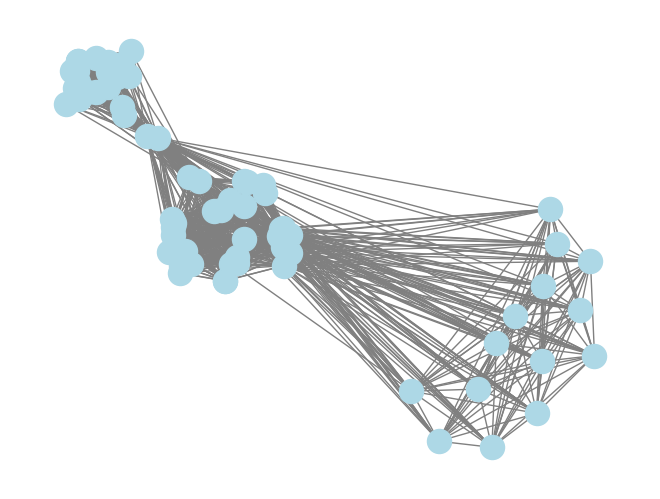

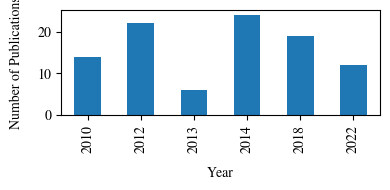


Most Frequent Collaborators for Jochenmartin Eppler:
name
morrison_abigail      177
diesmann_markus       111
helias_moritz          61
igarashi_jun           57
kunkel_susanne         51
plesser_hanse          49
marin_boris            38
plotnikov_dimitri      38
davison_andrewp        32
schmidt_maximilian     30
Name: count, dtype: int64


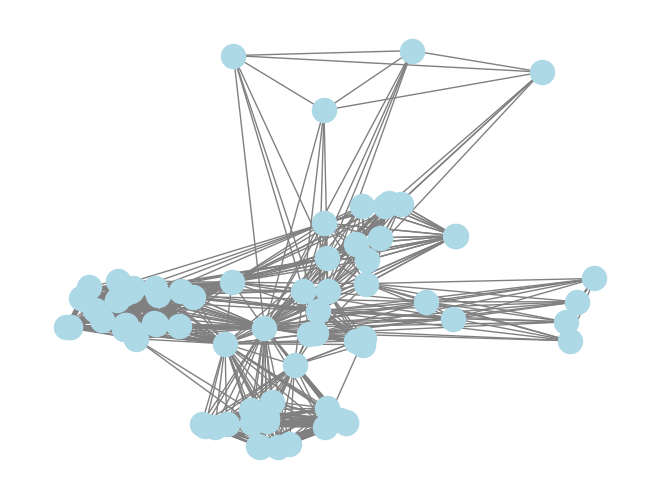

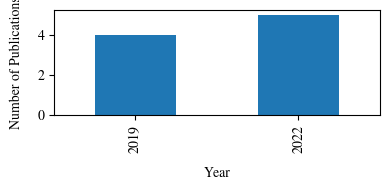


Most Frequent Collaborators for Anand Subramoney:
name
morrison_abigail      15
kappel_david          12
yegenoglu_alper       10
hoff_michael           8
diazpier_sandra        5
hater_thorsten         5
herty_michael          5
vandervlag_michiel     5
martin_aaronperez      5
klijn_wouter           5
Name: count, dtype: int64


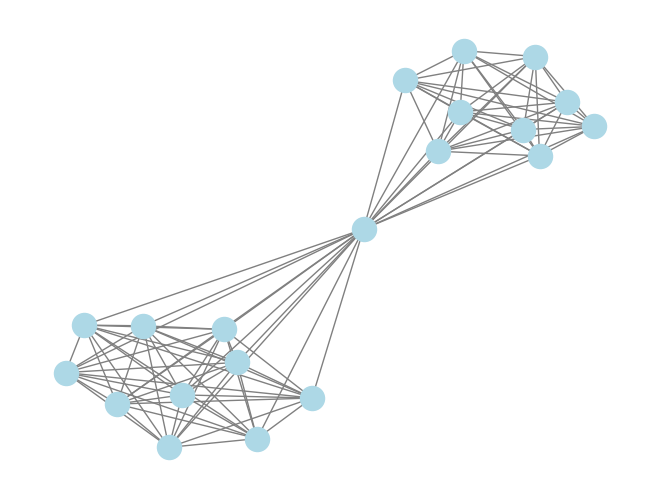

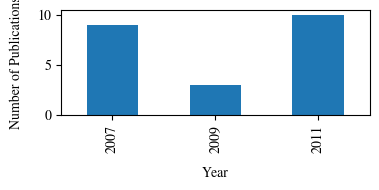


Most Frequent Collaborators for Eilif Muller:
name
diesmann_markus          30
potjans_tobiasc          20
davison_andrewp          13
hines_michaell           12
deoliveira_danhusmann    10
partzsch_johannes        10
mueller_paul             10
breitwieser_oliver       10
petkov_venelin           10
muller_lyle              10
Name: count, dtype: int64


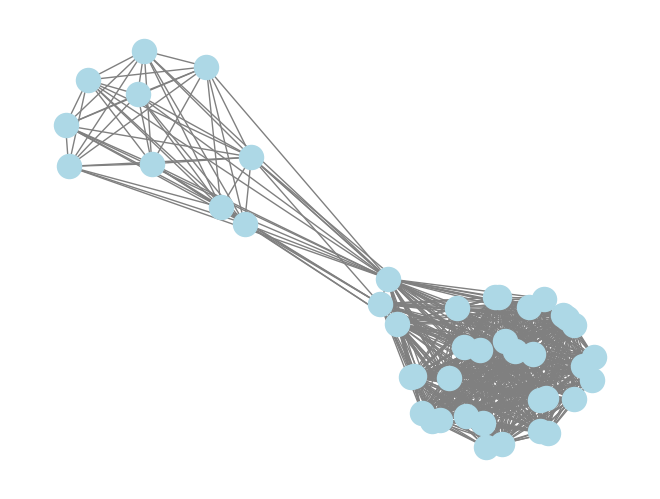

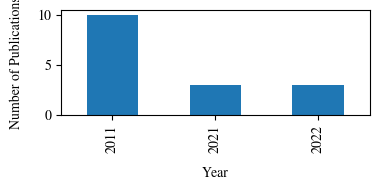


Most Frequent Collaborators for Johannes Schemmel:
name
diesmann_markus       30
potjans_tobiasc       20
petrovici_mihaia      16
vogginger_bernhard    13
meier_karlheinz       13
partzsch_johannes     13
gruebl_andreas        13
mueller_eric          13
mueller_paul          13
jeltsch_sebastian     13
Name: count, dtype: int64


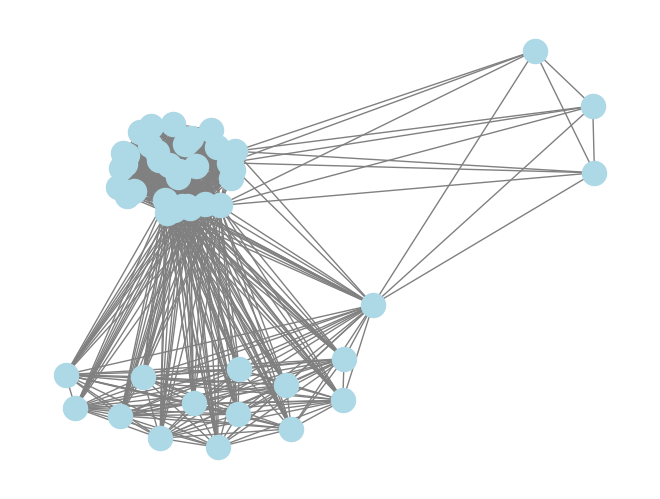

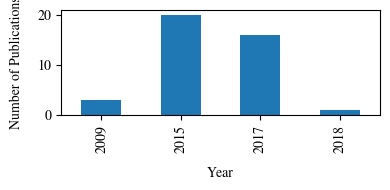


Most Frequent Collaborators for Michael Breakspear:
name
ritter_petra              60
roberts_jamesa            16
mcintosh_anthonyrandal    13
jirsa_viktork             10
friston_karlj              8
rubinov_mikail             3
valenzuela_michaelj        3
heitmann_stewart           1
aburn_matthewj             1
Name: count, dtype: int64


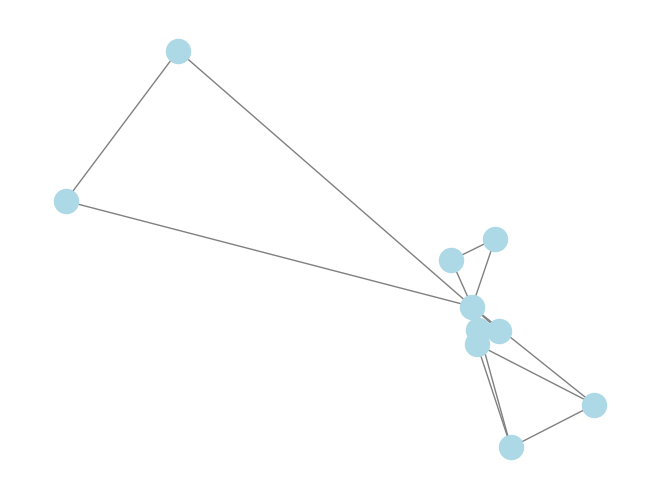

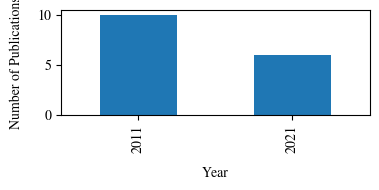


Most Frequent Collaborators for Mihaia Petrovici:
name
diesmann_markus      30
potjans_tobiasc      20
meier_karlheinz      13
schemmel_johannes    13
bruederle_daniel     10
scholze_stefan       10
kremkow_jens         10
lundqvist_mikael     10
muller_eilif         10
partzsch_johannes    10
Name: count, dtype: int64


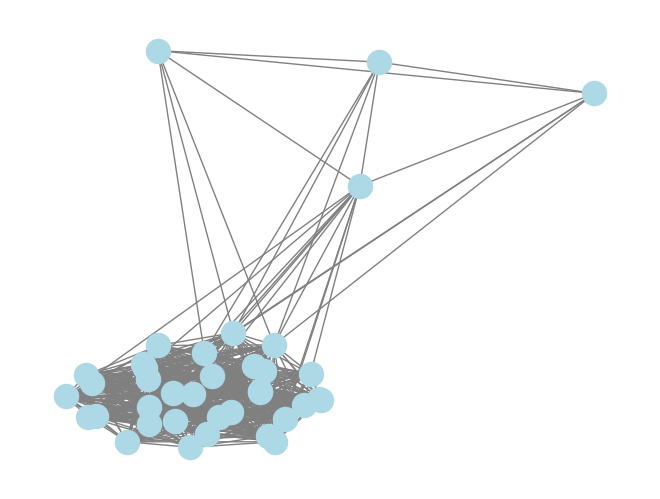

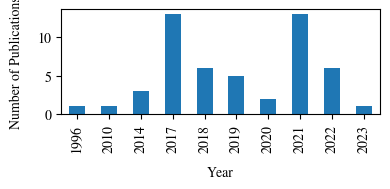


Most Frequent Collaborators for Karlj Friston:
name
stephan_klaasenno      21
owens_andrewp          18
allen_micah            18
roberts_jamesa         16
breakspear_michael     16
lomakina_ekaterinai    15
badcock_paul           15
smith_ryan             15
ondobaka_sasha         12
gallerosalas_yasir     10
Name: count, dtype: int64


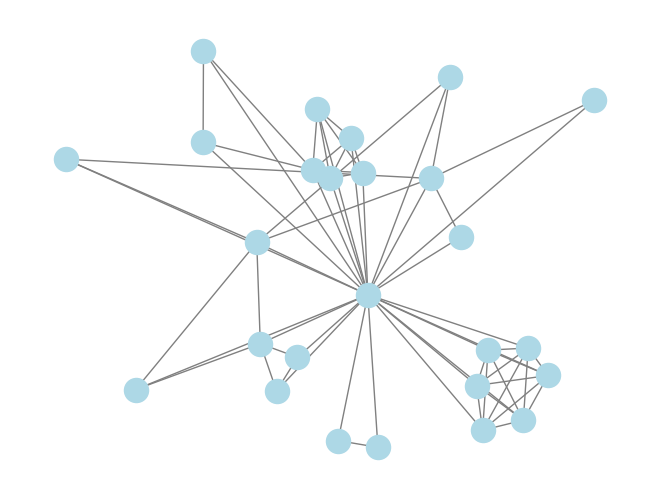

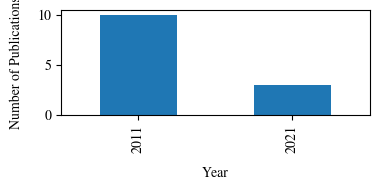


Most Frequent Collaborators for Karlheinz Meier:
name
diesmann_markus          30
potjans_tobiasc          20
petrovici_mihaia         16
schemmel_johannes        13
scholze_stefan           10
krishnamurthy_pradeep    10
kremkow_jens             10
lundqvist_mikael         10
muller_eilif             10
partzsch_johannes        10
Name: count, dtype: int64


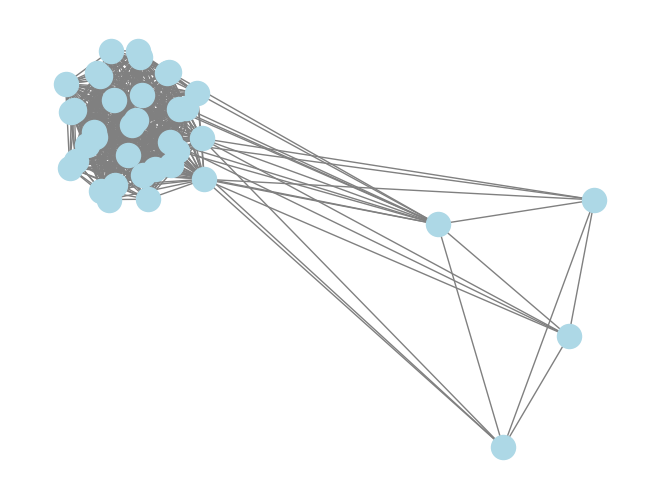

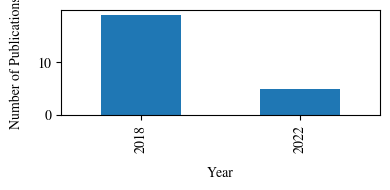


Most Frequent Collaborators for Sandra Diazpier:
name
morrison_abigail     72
marin_boris          38
plotnikov_dimitri    38
hines_michaell       19
richmond_paul        19
lester_davidr        19
mueller_eric         19
nowotny_thomas       19
peyser_alexander     19
rowley_andrewg       19
Name: count, dtype: int64


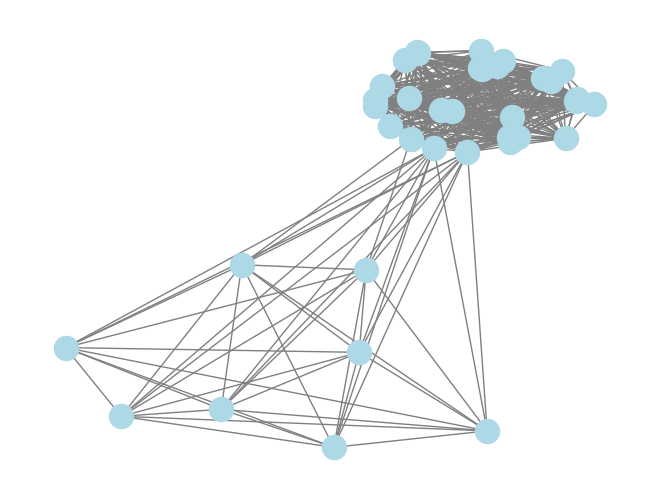

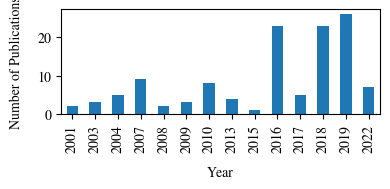


Most Frequent Collaborators for Michaell Hines:
name
lytton_williamw           93
mcdougal_roberta          86
durabernal_salvador       59
morrison_abigail          57
gleeson_padraig           49
seidenstein_alexandrah    40
plotnikov_dimitri         38
marin_boris               38
davison_andrewp           33
kumbhar_pramod            28
Name: count, dtype: int64


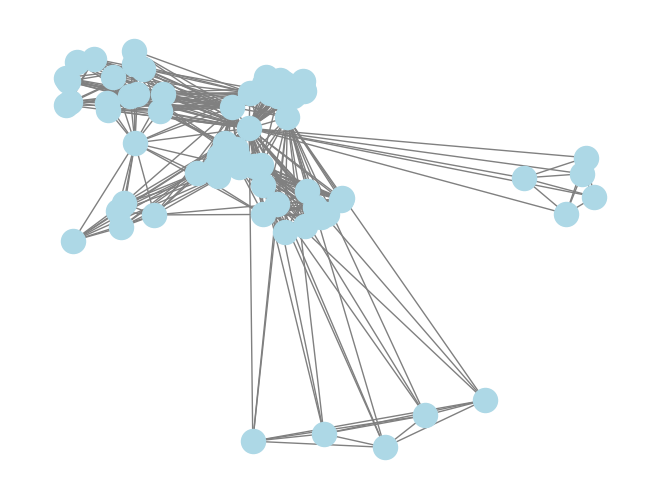

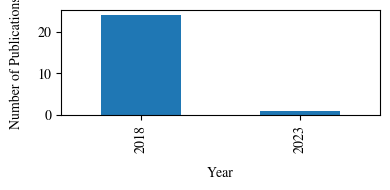


Most Frequent Collaborators for Michaelw Hopkins:
name
morrison_abigail           57
plotnikov_dimitri          38
marin_boris                38
rowley_andrewg             24
stokes_alanb               24
lester_davidr              24
musoles_carlosfernandez    19
kumbhar_pramod             19
mueller_eric               19
nowotny_thomas             19
Name: count, dtype: int64


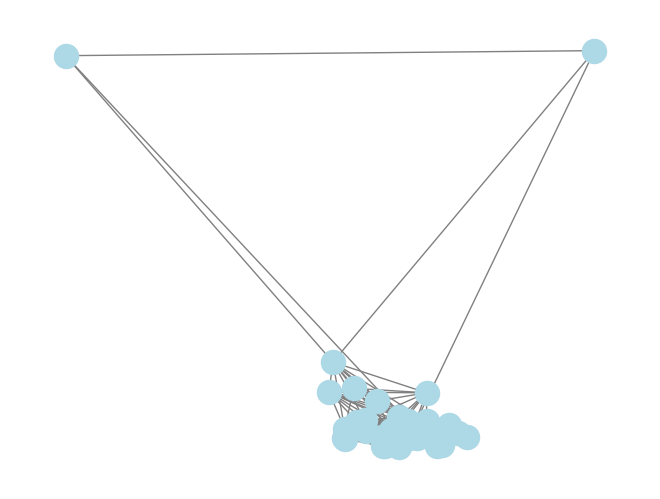

In [109]:
pattern = r'^([^\s]+)'

# get Pandas Array from Dataframe
ar_centralities = pd.DataFrame.to_numpy(df_top_10_centralities)

# concat Arrays to eachother
ar_centralities_conc = np.concatenate(ar_centralities)

# extract names with regex
names = []
for i in ar_centralities_conc:
	match = re.search(pattern, i)[0]
	names.append(match)

# filter unique names
names = list(dict.fromkeys(names))

#names
# run wrapper function for all names
for name in names:
	visualize_author(name)


